In [1]:
%load_ext autoreload

In [2]:
import os
import torch
import parkinson

import pandas as pd
import numpy as np

from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [3]:
RDN = 50
N_CLASSES = 2
BATCH_SIZE = 64
N_EPOCHS = 200
PATIENCE = 20
LR = 0.0001
DECAY = 0.000001
SAVE_PATH = '../outputs/2.2_2etapas'

# Processamento dos dados

In [4]:
# Lendo os dados dos arquivos.
print('Started file reading...')
parkinson_data = parkinson.utils.data.batch_read('../data/PDs_columns')
control_data = parkinson.utils.data.batch_read('../data/Controls_columns')
prodomal_data = parkinson.utils.data.batch_read('../data/Prodomals_columns')
print('File reading completed.')

# Selecionando o atlas (estratégia de divisão cerebral: Shen_268 ou atlas ou AAL3).
control_atlas_data = parkinson.utils.data.select_atlas_columns(control_data, 'AAL3')
parkinson_atlas_data = parkinson.utils.data.select_atlas_columns(parkinson_data, 'AAL3')
prodomal_atlas_data = parkinson.utils.data.select_atlas_columns(prodomal_data, 'AAL3')

# Transformando os dados selecionados em séries temporais (shape = [n_pacientes, n_canais, n_observações]).
control_ts_data = parkinson.utils.data.df_to_timeseries(control_atlas_data)
parkinson_ts_data = parkinson.utils.data.df_to_timeseries(parkinson_atlas_data)
prodomal_ts_data = parkinson.utils.data.df_to_timeseries(prodomal_atlas_data)

# Misturando pacientes Controle/Parkinson e trocando valores NaN por zero.
X = parkinson.utils.data.concatenate_data(parkinson_ts_data, control_ts_data, prodomal_ts_data)
y = parkinson.utils.data.concatenate_data([1 for _ in range(len(parkinson_data))], [0 for _ in range(len(control_data))], [2 for _ in range(len(prodomal_data))])
X, y = parkinson.utils.data.filter_data(X, y)

# Separando os dados em 80% treino das 2 etapas e 20% teste.
X_train_2etapas, X_test_final, y_train_2etapas, y_test_final = train_test_split(X, y, test_size=0.1, random_state=RDN, stratify=y, shuffle=True)

# Separando os dados da primeira etapa (Control vs Não Saudáveis).
X_1step = X_train_2etapas
y_1step = np.where(y_train_2etapas == 2, 1, y_train_2etapas)
X_1step_trainval, X_1step_test, y_1step_trainval, y_1step_test = train_test_split(X_1step, y_1step, test_size=0.1, random_state=RDN, stratify=y_train_2etapas, shuffle=True)
X_1step_train, X_1step_val, y_1step_train, y_1step_val = train_test_split(X_1step_trainval, y_1step_trainval, test_size=1/9, random_state=RDN, stratify=y_1step_trainval, shuffle=True)

# Separando os dados da segunda etapa (Parkinson vs Prodomals).
X_2step = X_train_2etapas[y_train_2etapas != 0]
y_2step = y_train_2etapas[y_train_2etapas != 0]
y_2step = np.where(y_2step == 2, 0, y_2step)
X_2step_trainval, X_2step_test, y_2step_trainval, y_2step_test = train_test_split(X_2step, y_2step, test_size=0.1, random_state=RDN, stratify=y_2step, shuffle=True)
X_2step_train, X_2step_val, y_2step_train, y_2step_val = train_test_split(X_2step_trainval, y_2step_trainval, test_size=1/9, random_state=RDN, stratify=y_2step_trainval, shuffle=True)

# Criando DataLoader
test_final_loader = parkinson.utils.data.get_torch_dataloader(X_test_final, y_test_final, batch_size=BATCH_SIZE)

train_1step_loader = parkinson.utils.data.get_torch_dataloader(X_1step_train, y_1step_train, batch_size=BATCH_SIZE)
val_1step_loader = parkinson.utils.data.get_torch_dataloader(X_1step_val, y_1step_val, batch_size=BATCH_SIZE)
test_1step_loader = parkinson.utils.data.get_torch_dataloader(X_1step_test, y_1step_test, batch_size=BATCH_SIZE)

train_2step_loader = parkinson.utils.data.get_torch_dataloader(X_2step_train, y_2step_train, batch_size=BATCH_SIZE)
val_2step_loader = parkinson.utils.data.get_torch_dataloader(X_2step_val, y_2step_val, batch_size=BATCH_SIZE)
test_2step_loader = parkinson.utils.data.get_torch_dataloader(X_2step_test, y_2step_test, batch_size=BATCH_SIZE)

Started file reading...


100%|██████████| 188/188 [00:08<00:00, 21.50it/s]


File reading completed.


# Treinamento Control vs Não Saudáveis (1 step)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = parkinson.NetworkModels.customFCN(X_1step_train.shape[1], N_CLASSES)

model.train()
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_1step_train), y=y_1step_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

out1 = parkinson.utils.train.train(model, train_1step_loader, val_1step_loader, device, N_EPOCHS, PATIENCE, LR, "../weights/2.2_2etapas/1step", DECAY)

metrics1 = parkinson.utils.train.evaluate(model, test_1step_loader, device, "../weights/2.2_2etapas/1step")

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]/home/labic/merlin_codes/dl/Parkinson-Diagnosis-Deeplearning/.venv/lib/python3.12/site-packages/torch/nn/modules/conv.py:370: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv1d(
train-loss: 0.0196  train-acc: 1.0000 | val-loss: 0.4244  val-acc: 0.8378:  31%|███       | 62/200 [00:42<01:34,  1.46it/s]

Early stopping at epoch 63



/home/labic/merlin_codes/dl/Parkinson-Diagnosis-Deeplearning/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Treinamento Parkinson vs Prodomals (2 step)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = parkinson.NetworkModels.customFCN(X_2step_trainval.shape[1], N_CLASSES)

model.train()
criterion = nn.CrossEntropyLoss()

out2 = parkinson.utils.train.train(model, train_2step_loader, val_2step_loader, device, N_EPOCHS, PATIENCE, LR, "../weights/2.2_2etapas/2step", DECAY)

metrics2 = parkinson.utils.train.evaluate(model, test_2step_loader, device, "../weights/2.2_2etapas/2step")

train-loss: 0.0184  train-acc: 1.0000 | val-loss: 0.6552  val-acc: 0.5806:  16%|█▌        | 32/200 [00:18<01:38,  1.71it/s]

Early stopping at epoch 33


# Análise dos resultados

## 1 Step

 Acurácia       F1  Precisão   Recall
 0.837838 0.763911  0.701972 0.837838


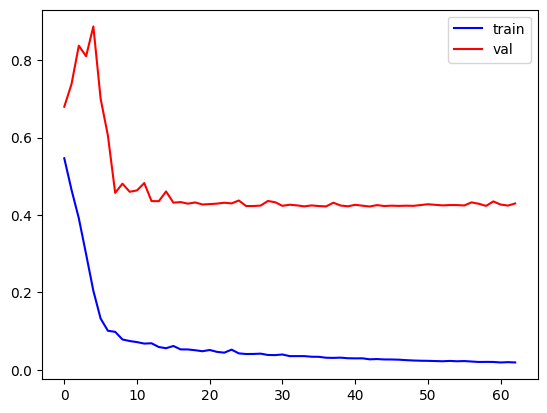

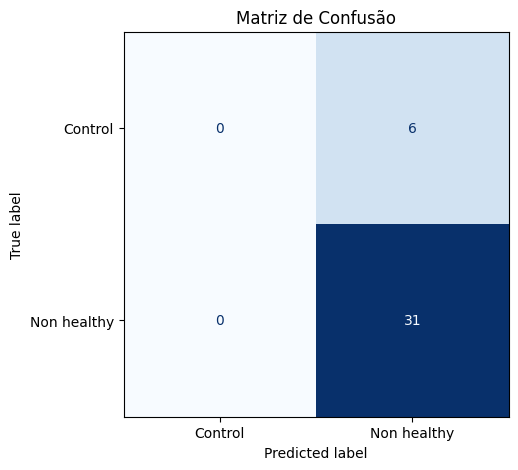

In [7]:
# Criando e plotando os resultados.
parkinson.utils.results.metrics_to_dataframe(metrics1)
fig_loss = parkinson.utils.results.plot_losses(out1['train_loss'],out1['val_loss'])
fig_loss.show()
fig_cf = parkinson.utils.results.plot_confusion_matrix(metrics1['preds'], metrics1['labels'], class_names=['Control','Non healthy'])
fig_cf.show()

# Salvando as figuras.
fig_loss.savefig(f"{SAVE_PATH}/1step/loss_curve.png", bbox_inches='tight')
fig_cf.savefig(f"{SAVE_PATH}/1step/confusion_matrix.png", bbox_inches='tight')

## 2 Step

 Acurácia       F1  Precisão   Recall
 0.419355 0.419355  0.419355 0.419355


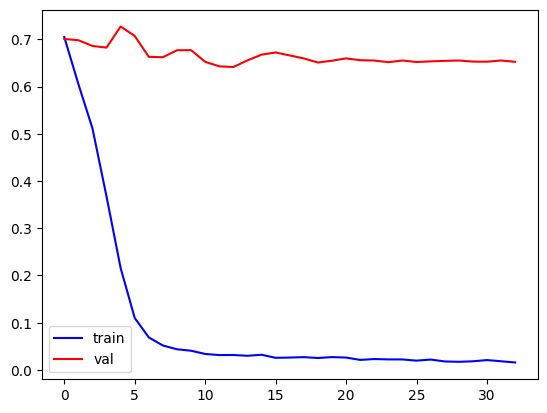

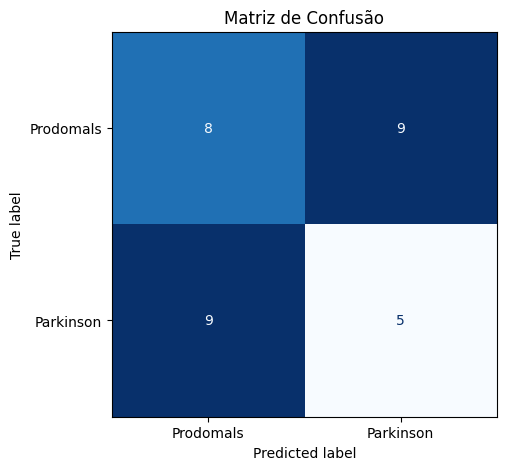

In [8]:
# Criando e plotando os resultados.
parkinson.utils.results.metrics_to_dataframe(metrics2)
fig_loss = parkinson.utils.results.plot_losses(out2['train_loss'],out2['val_loss'])
fig_loss.show()
fig_cf = parkinson.utils.results.plot_confusion_matrix(metrics2['preds'], metrics2['labels'], class_names=['Prodomals','Parkinson'])
fig_cf.show()

# Salvando as figuras.
fig_loss.savefig(f"{SAVE_PATH}/2step/loss_curve.png", bbox_inches='tight')
fig_cf.savefig(f"{SAVE_PATH}/2step/confusion_matrix.png", bbox_inches='tight')

# Treinamento Modelo Final

In [9]:
model1 = parkinson.NetworkModels.customFCN(X_1step_train.shape[1], N_CLASSES).to(device)
model1.load_state_dict(torch.load("../weights/2.2_2etapas/1step/best_model.pth", map_location=device))

model2 = parkinson.NetworkModels.customFCN(X_2step_train.shape[1], N_CLASSES).to(device)
model2.load_state_dict(torch.load("../weights/2.2_2etapas/2step/best_model.pth", map_location=device))

<All keys matched successfully>

In [10]:
all_preds = []
all_true = []

model1.eval()
model2.eval()
with torch.no_grad():
    for X_batch, y_batch in test_final_loader:
        for i in range(X_batch.shape[0]):
            x = X_batch[i].unsqueeze(0).to(device)
            y_true = y_batch[i].item()
            all_true.append(y_true)
            output1 = model1(x)
            pred1 = output1.argmax(dim=1).item()
            if pred1 == 0:
                all_preds.append(0)  # Control
            else:
                output2 = model2(x)
                pred2 = output2.argmax(dim=1).item()
                if pred2 == 1:
                    all_preds.append(1)  # Parkinson
                else:
                    all_preds.append(2)  # Prodomal

   Acurácia        F1  Precisão    Recall
0  0.487805  0.444518  0.408624  0.487805


/home/labic/merlin_codes/dl/Parkinson-Diagnosis-Deeplearning/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


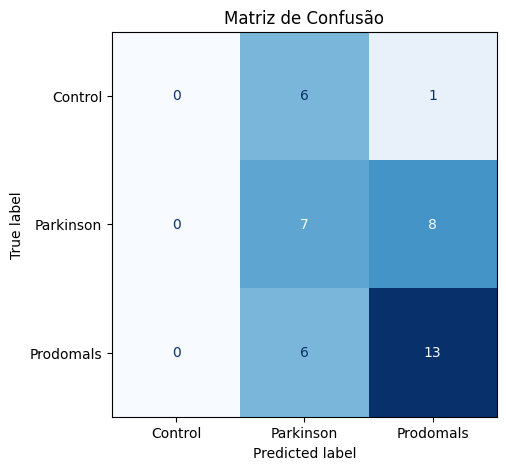

In [11]:
# Calculando métricas gerais para o modelo final (3 classes)
df_metrics = pd.DataFrame({
    'Acurácia': [accuracy_score(all_true, all_preds)],
    'F1': [f1_score(all_true, all_preds, average='weighted')],
    'Precisão': [precision_score(all_true, all_preds, average='weighted')],
    'Recall': [recall_score(all_true, all_preds, average='weighted')]
})
print(df_metrics)

# Criando e plotando os resultados.
fig_cf = parkinson.utils.results.plot_confusion_matrix(all_preds, all_true, class_names=['Control','Parkinson', 'Prodomals'])
fig_cf.show()

# Salvando as figuras.
fig_cf.savefig(f"{SAVE_PATH}/confusion_matrix.png", bbox_inches='tight')